# Notebook 2 — TimeGAN Training

This notebook implements and trains the full **TimeGAN** architecture (Yoon et al., 2019) applied to our six-asset financial time series dataset.

TimeGAN is a GAN variant specifically designed for sequential data. Its key innovation over a standard GAN is the introduction of a **supervised loss** that forces the Generator to learn the stepwise conditional distribution of the real data — not just its marginal distribution. This is achieved through a dedicated Supervisor network trained on real embeddings, which acts as a temporal regulariser during joint adversarial training.

The training proceeds in **three phases**:
1. **Autoencoder pre-training** — the Embedder and Recovery learn a compressed latent representation of the real data
2. **Supervised pre-training** — the Supervisor learns to predict the next embedding step, capturing temporal dynamics
3. **Joint adversarial training** — all five components are trained together with four coordinated loss terms

At the end, we generate `n_windows` synthetic samples and run a quick visual sanity check before the rigorous evaluation in Notebook 3.

## 1. Setup & GPU Check

Training TimeGAN without a GPU is feasible but slow at 10k steps per phase. Confirm T4 is active before proceeding.

In [1]:
import os
import json
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

warnings.filterwarnings('ignore')

# --- Reproducibility ---
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# --- GPU check ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f'GPU available: {gpus[0].name}')
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print('WARNING: No GPU detected. Training will be slow. Switch to T4 runtime in Colab.')

print(f'TensorFlow: {tf.__version__}')

plt.style.use('seaborn-v0_8-whitegrid')
COLORS = ['#2196F3', '#FF5722', '#4CAF50', '#9C27B0', '#FF9800', '#00BCD4']

TensorFlow: 2.20.0


## 2. Load Data

In [2]:
windows     = np.load('data/windows.npy').astype(np.float32)   # (n_windows, 24, 6)
scaled_data = np.load('data/scaled_data.npy').astype(np.float32)

with open('data/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('data/tickers.json') as f:
    TICKERS = json.load(f)

print(f'Windows shape:     {windows.shape}  →  (n_windows, seq_len, n_features)')
print(f'Value range:       [{windows.min():.4f}, {windows.max():.4f}]')
print(f'Tickers:           {TICKERS}')

Windows shape:     (3750, 24, 6)  →  (n_windows, seq_len, n_features)
Value range:       [0.0000, 1.0000]
Tickers:           ['SPY', 'GLD', 'TLT', 'XLE', 'MSFT', 'JPM']


## 3. Hyperparameter Block

All architectural and training hyperparameters are defined in a single cell. Centralising them here makes it easy to run ablation experiments without hunting through the notebook.

Key choices:
- `hidden_dim = 24` matches `seq_len`, a heuristic from Jansen that works well for financial series of this length
- `num_layers = 3` gives the GRU enough depth to capture multi-scale temporal patterns without overfitting on ~3700 windows
- `gamma = 1` is the standard weighting for the moment loss — equal weight to the adversarial and statistical moment objectives

In [3]:
# --- Data dimensions (read from loaded arrays, not hard-coded) ---
n_windows, seq_len, n_seq = windows.shape

# --- Architecture ---
hidden_dim = 24        # Latent space dimensionality; matching seq_len is a documented TimeGAN convention
num_layers = 3         # Stack depth for each GRU component

# --- Training ---
batch_size         = 128    # Large enough for stable GAN gradients, small enough to fit T4 VRAM
learning_rate      = 1e-3   # Adam default; decayed implicitly by gradient noise in GAN training
train_steps        = 10_000 # Phase 1 (autoencoder) and Phase 2 (supervisor)
joint_train_steps  = 10_000 # Phase 3 (joint adversarial)

# --- Loss weighting ---
gamma = 1   # Weight of the moment-matching loss relative to adversarial loss

print('Hyperparameters:')
hp = dict(seq_len=seq_len, n_seq=n_seq, n_windows=n_windows, hidden_dim=hidden_dim,
          num_layers=num_layers, batch_size=batch_size, learning_rate=learning_rate,
          train_steps=train_steps, joint_train_steps=joint_train_steps, gamma=gamma)
for k, v in hp.items():
    print(f'  {k:<22} {v}')

Hyperparameters:
  seq_len                24
  n_seq                  6
  n_windows              3750
  hidden_dim             24
  num_layers             3
  batch_size             128
  learning_rate          0.001
  train_steps            10000
  joint_train_steps      10000
  gamma                  1


## 4. Data Pipeline

We build two data sources:
1. A `tf.data.Dataset` over real windows — shuffled, batched, and repeated indefinitely so we can pull batches for any number of training steps
2. A noise generator function — samples Gaussian noise `Z ~ N(0, 1)` with shape `(batch, seq_len, n_seq)` to drive the Generator

In [4]:
# Real data pipeline: shuffle ensures batches span different time periods and regimes
real_dataset = (
    tf.data.Dataset
    .from_tensor_slices(windows)
    .shuffle(buffer_size=n_windows, seed=SEED, reshuffle_each_iteration=True)
    .batch(batch_size, drop_remainder=True)
    .repeat()          # Repeat indefinitely — we control training via step count, not epochs
    .prefetch(tf.data.AUTOTUNE)
)
real_iter = iter(real_dataset)

def get_noise(batch_sz=batch_size):
    """Sample isotropic Gaussian noise for the Generator input.
    
    Gaussian noise is preferred over uniform here because the Generator's GRU
    cells can produce richer dynamics from a smooth, unbounded noise distribution.
    """
    return tf.random.normal(shape=(batch_sz, seq_len, n_seq), seed=SEED)

print(f'Real dataset: {n_windows} windows → batches of {batch_size}')
print(f'Noise shape:  ({batch_size}, {seq_len}, {n_seq})')

# Smoke test
sample_real  = next(real_iter)
sample_noise = get_noise()
print(f'Sample real batch:  {sample_real.shape}')
print(f'Sample noise batch: {sample_noise.shape}')

Real dataset: 3750 windows → batches of 128
Noise shape:  (128, 24, 6)
Sample real batch:  (128, 24, 6)
Sample noise batch: (128, 24, 6)


## 5. Architecture — GRU Block Factory

All five TimeGAN components (Embedder, Recovery, Generator, Supervisor, Discriminator) share the same GRU backbone. Rather than defining five nearly identical model builders, we use a single factory function `make_rnn()` parametrised by output dimensionality and activation.

**GRU vs LSTM:** GRU has fewer parameters than LSTM (no separate cell state) and trains faster, which matters at 30k total steps. For financial time series at the daily frequency, GRU's simplified gating is generally sufficient — the long-range dependencies that would benefit from LSTM's cell state are less relevant at a 24-step horizon than at, say, 252-step (annual) horizons.

In [5]:
def make_rnn(output_dim, activation, name, input_dim=None):
    """Build a stacked GRU network wrapped in the Keras functional API.
    
    Args:
        output_dim:  Dimensionality of the Dense output layer.
        activation:  Output activation ('sigmoid' for [0,1] outputs, 'tanh' for latent space,
                     'linear' for regression targets, 'sigmoid' for binary classification).
        name:        Model name — important for isolating trainable variables per component.
        input_dim:   Feature size of the incoming tensor. Defaults to n_seq (data space).
                     Components that receive latent embeddings (Recovery, Supervisor,
                     Discriminator) must pass hidden_dim here — they live in latent space,
                     not raw feature space.
    
    Returns:
        A Keras Model built with the functional API.
    """
    in_dim = input_dim if input_dim is not None else n_seq
    inp = keras.Input(shape=(seq_len, in_dim), name=f'{name}_input')
    x = inp

    # Stacked GRU: all layers return sequences so the next layer
    # receives a full-length sequence, not just the final hidden state
    for i in range(num_layers):
        x = layers.GRU(
            units=hidden_dim,
            return_sequences=True,
            name=f'{name}_gru_{i}'
        )(x)

    # Time-distributed Dense applies the same linear projection at every timestep
    out = layers.TimeDistributed(
        layers.Dense(output_dim, activation=activation),
        name=f'{name}_output'
    )(x)

    return keras.Model(inp, out, name=name)


print('make_rnn() factory defined.')
print(f'  Shared config: hidden_dim={hidden_dim}, num_layers={num_layers}, seq_len={seq_len}, n_seq={n_seq}')


make_rnn() factory defined.
  Shared config: hidden_dim=24, num_layers=3, seq_len=24, n_seq=6


## 6. Instantiate the Five Components

Each component has a distinct role and output activation:

| Component | Input | Output | Activation | Role |
|-----------|-------|--------|------------|------|
| **Embedder** `H` | Real data `X` (n_seq) | Latent `H` (hidden_dim) | `sigmoid` | Maps real data to latent space |
| **Recovery** `R` | Latent `H` (hidden_dim) | Reconstructed `X̂` (n_seq) | `sigmoid` | Maps latent back to data space |
| **Generator** `E` | Noise `Z` (n_seq) | Fake latent `H̃` (hidden_dim) | `sigmoid` | Generates synthetic embeddings |
| **Supervisor** `S` | Latent `H` (hidden_dim) | Next-step latent (hidden_dim) | `sigmoid` | Learns temporal transitions |
| **Discriminator** `D` | Latent `H` (hidden_dim) | Real/fake prob (1) | `sigmoid` | Distinguishes real vs generated embeddings |

In [6]:
# Embedder and Generator receive data-space / noise inputs (n_seq features)
# Recovery, Supervisor, and Discriminator receive latent embeddings (hidden_dim features)
embedder      = make_rnn(output_dim=hidden_dim, activation='sigmoid', name='embedder',      input_dim=n_seq)
recovery      = make_rnn(output_dim=n_seq,       activation='sigmoid', name='recovery',      input_dim=hidden_dim)
generator     = make_rnn(output_dim=hidden_dim, activation='sigmoid', name='generator',     input_dim=n_seq)
supervisor    = make_rnn(output_dim=hidden_dim, activation='sigmoid', name='supervisor',    input_dim=hidden_dim)
discriminator = make_rnn(output_dim=1,           activation='sigmoid', name='discriminator', input_dim=hidden_dim)

for model in [embedder, recovery, generator, supervisor, discriminator]:
    n_params = model.count_params()
    print(f'{model.name:<16}  input_dim={model.input_shape[-1]}  output_dim={model.output_shape[-1]}  params: {n_params:>8,}')


embedder          input_dim=6  output_dim=24  params:   10,104
recovery          input_dim=24  output_dim=6  params:   10,950
generator         input_dim=6  output_dim=24  params:   10,104
supervisor        input_dim=24  output_dim=24  params:   11,400
discriminator     input_dim=24  output_dim=1  params:   10,825


## 7. Composite Keras Models

TimeGAN's training requires coordinated updates across subsets of its five components. We compose them into five Keras models so that each training step can cleanly target the right set of parameters via `model.trainable_variables`.

The `synthetic_data` model is the one we use at inference time: noise → Generator → Supervisor → Recovery → synthetic windows.

In [7]:
# --- Autoencoder: Embedder → Recovery ---
# Trained to minimise reconstruction loss on real data
X_input = keras.Input(shape=(seq_len, n_seq), name='X_input')
H        = embedder(X_input)
X_tilde  = recovery(H)
autoencoder = keras.Model(inputs=X_input, outputs=X_tilde, name='autoencoder')

# --- Adversarial supervised: Generator → Supervisor → Discriminator ---
# Used during joint training to compute the Generator's supervised adversarial loss
Z_input  = keras.Input(shape=(seq_len, n_seq), name='Z_input')
E_hat    = generator(Z_input)
H_hat    = supervisor(E_hat)
Y_fake   = discriminator(H_hat)
adversarial_supervised = keras.Model(inputs=Z_input, outputs=Y_fake, name='adversarial_supervised')

# --- Adversarial emb: Generator → Discriminator (bypasses Supervisor) ---
# Discriminates raw Generator output; provides an additional gradient signal to the Generator
Y_fake_e = discriminator(E_hat)
adversarial_emb = keras.Model(inputs=Z_input, outputs=Y_fake_e, name='adversarial_emb')

# --- Synthetic data: Generator → Supervisor → Recovery (inference path) ---
X_hat = recovery(H_hat)
synthetic_data = keras.Model(inputs=Z_input, outputs=X_hat, name='synthetic_data')

# --- Discriminator model: Embedder → Discriminator (classifies real embeddings) ---
Y_real = discriminator(H)
discriminator_model = keras.Model(inputs=X_input, outputs=Y_real, name='discriminator_model')

print('Composite models built:')
for m in [autoencoder, adversarial_supervised, adversarial_emb, synthetic_data, discriminator_model]:
    print(f'  {m.name}')

Composite models built:
  autoencoder
  adversarial_supervised
  adversarial_emb
  synthetic_data
  discriminator_model


## 8. Optimisers & Loss Functions

Three loss types are used across the three training phases:

- **MSE** (`reconstruction_loss`): Measures fidelity of the autoencoder's reconstruction. Used in Phase 1 and as part of the Generator's loss in Phase 3.
- **BCE** (`adversarial_loss`): Binary cross-entropy for the GAN's real/fake classification objective. Standard GAN loss.
- **Moment loss**: Penalises differences in the *mean* and *variance* of real vs synthetic data. This is TimeGAN's statistical regulariser — it prevents mode collapse by ensuring the Generator's output distribution matches the first two moments of the real distribution, even if the adversarial signal is weak early in training.

In [10]:
autoencoder_opt    = keras.optimizers.Adam(learning_rate=learning_rate)
supervisor_opt     = keras.optimizers.Adam(learning_rate=learning_rate)
generator_opt      = keras.optimizers.Adam(learning_rate=learning_rate)
discriminator_opt  = keras.optimizers.Adam(learning_rate=learning_rate)
embedder_opt       = keras.optimizers.Adam(learning_rate=learning_rate)


@tf.function
def reconstruction_loss(X, X_tilde):
    """MSE between real input and autoencoder reconstruction."""
    return tf.reduce_mean(tf.square(X - X_tilde))  # Manual MSE — tf.keras.losses.mse removed in Keras 3


@tf.function
def adversarial_loss(y_real_or_fake, is_real):
    """Standard BCE GAN loss with label smoothing on real labels."""
    labels = tf.ones_like(y_real_or_fake) * (0.9 if is_real else 0.0)
    bce = tf.keras.losses.BinaryCrossentropy()
    return bce(labels, y_real_or_fake)


@tf.function
def moment_loss(X, X_hat):
    """First and second moment matching between real and synthetic distributions."""
    mean_loss = tf.reduce_mean(tf.abs(tf.reduce_mean(X, axis=0) - tf.reduce_mean(X_hat, axis=0)))
    var_loss  = tf.reduce_mean(tf.abs(tf.math.reduce_variance(X, axis=0) - tf.math.reduce_variance(X_hat, axis=0)))
    return mean_loss + var_loss


print('Optimisers and loss functions defined.')

Optimisers and loss functions defined.


## 9. Phase 1 — Autoencoder Pre-training

We train the Embedder and Recovery jointly to reconstruct real data windows with minimal MSE loss. This establishes a meaningful latent space before the Generator is introduced. Without this pre-training, the Generator would be optimising against a Discriminator that hasn't yet learned a useful representation — the training signal would be too noisy to converge.

The supervised loss on the Supervisor (`H_{t+1}` prediction from `H_t`) is also included here — this is a cheap way to warm-start the Supervisor using the Embedder's latent space before Phase 2.

In [11]:
@tf.function
def train_autoencoder_step(X):
    with tf.GradientTape() as tape:
        H       = embedder(X, training=True)
        X_tilde = recovery(H, training=True)
        # Supervisor auxiliary loss: predict H_{t+1} from H_t to warm-start temporal learning
        H_hat_s = supervisor(H, training=True)
        G_loss_S = reconstruction_loss(H[:, 1:, :], H_hat_s[:, :-1, :])  # Shift by 1 step

        loss = 10 * reconstruction_loss(X, X_tilde) + 0.1 * G_loss_S

    # Joint update: Embedder, Recovery, and Supervisor all benefit from reconstruction signal
    vars_ = embedder.trainable_variables + recovery.trainable_variables + supervisor.trainable_variables
    grads = tape.gradient(loss, vars_)
    autoencoder_opt.apply_gradients(zip(grads, vars_))
    return loss


print('Phase 1: Autoencoder pre-training')
print(f'Steps: {train_steps:,}  |  Logging every 1,000 steps')
print('-' * 50)

phase1_losses = []
for step in range(train_steps):
    X_batch = next(real_iter)
    loss    = train_autoencoder_step(X_batch)
    phase1_losses.append(float(loss))

    if (step + 1) % 1000 == 0:
        print(f'  Step {step+1:>6,}  |  Reconstruction loss: {loss:.6f}')

print('Phase 1 complete.')

Phase 1: Autoencoder pre-training
Steps: 10,000  |  Logging every 1,000 steps
--------------------------------------------------
  Step  1,000  |  Reconstruction loss: 0.008680
  Step  2,000  |  Reconstruction loss: 0.005069
  Step  3,000  |  Reconstruction loss: 0.005488
  Step  4,000  |  Reconstruction loss: 0.004108
  Step  5,000  |  Reconstruction loss: 0.003221
  Step  6,000  |  Reconstruction loss: 0.003100
  Step  7,000  |  Reconstruction loss: 0.002514
  Step  8,000  |  Reconstruction loss: 0.002034
  Step  9,000  |  Reconstruction loss: 0.001496
  Step 10,000  |  Reconstruction loss: 0.001070
Phase 1 complete.


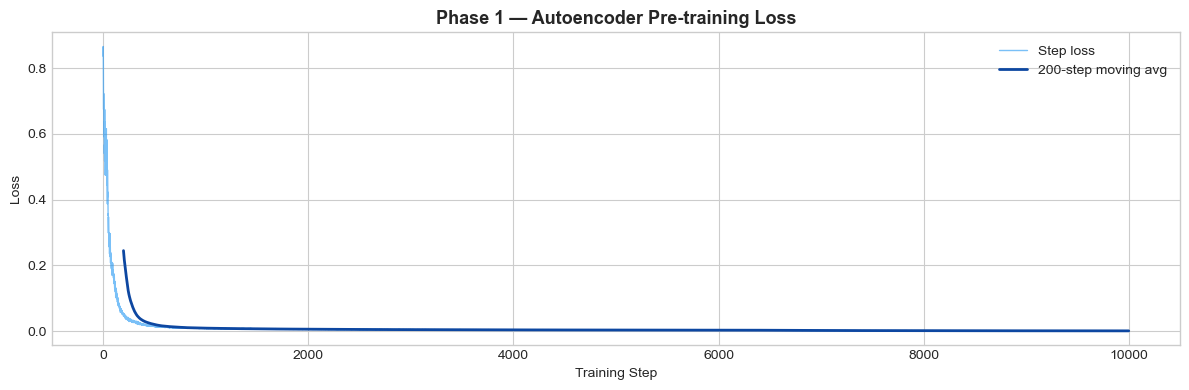

In [13]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(phase1_losses, color='#2196F3', linewidth=1, alpha=0.6, label='Step loss')

# Smooth with a rolling window to reveal the trend through GAN noise
window = 200
smoothed = pd.Series(phase1_losses).rolling(window).mean()
ax.plot(smoothed, color='#0D47A1', linewidth=2, label=f'{window}-step moving avg')

ax.set_title('Phase 1 — Autoencoder Pre-training Loss', fontsize=13, fontweight='bold')
ax.set_xlabel('Training Step')
ax.set_ylabel('Loss')
ax.legend()
plt.tight_layout()
import os
if not os.path.exists('output'):
    os.makedirs('output')
plt.savefig('output/phase1_loss.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Phase 2 — Supervised Pre-training

The Supervisor is trained to predict the next latent embedding step from the current one: `H_{t+1} = S(H_t)`. This is the **key innovation of TimeGAN** relative to a standard GAN.

A vanilla GAN operates on i.i.d. samples — it has no mechanism to learn that `X_{t+1}` should follow from `X_t` in a physically plausible way. TimeGAN solves this by adding the Supervisor as a sequential prior. During joint training, the Generator must satisfy both the adversarial objective (fool the Discriminator) **and** the supervised objective (produce latent sequences whose transitions look like real ones). This dual constraint is what makes TimeGAN's synthetic sequences temporally coherent rather than just marginally realistic.

In [14]:
@tf.function
def train_supervisor_step(X):
    with tf.GradientTape() as tape:
        H       = embedder(X, training=True)
        H_hat_s = supervisor(H, training=True)
        # Shift by 1: predict step t+1 from the embedding at step t
        loss = reconstruction_loss(H[:, 1:, :], H_hat_s[:, :-1, :])

    vars_ = supervisor.trainable_variables + embedder.trainable_variables
    grads = tape.gradient(loss, vars_)
    supervisor_opt.apply_gradients(zip(grads, vars_))
    return loss


print('Phase 2: Supervised pre-training (Supervisor)')
print(f'Steps: {train_steps:,}  |  Logging every 1,000 steps')
print('-' * 50)

phase2_losses = []
for step in range(train_steps):
    X_batch = next(real_iter)
    loss    = train_supervisor_step(X_batch)
    phase2_losses.append(float(loss))

    if (step + 1) % 1000 == 0:
        print(f'  Step {step+1:>6,}  |  Supervisor loss: {loss:.6f}')

print('Phase 2 complete.')

Phase 2: Supervised pre-training (Supervisor)
Steps: 10,000  |  Logging every 1,000 steps
--------------------------------------------------
  Step  1,000  |  Supervisor loss: 0.000002
  Step  2,000  |  Supervisor loss: 0.000001
  Step  3,000  |  Supervisor loss: 0.000002
  Step  4,000  |  Supervisor loss: 0.000000
  Step  5,000  |  Supervisor loss: 0.000000
  Step  6,000  |  Supervisor loss: 0.000000
  Step  7,000  |  Supervisor loss: 0.000001
  Step  8,000  |  Supervisor loss: 0.000000
  Step  9,000  |  Supervisor loss: 0.000000
  Step 10,000  |  Supervisor loss: 0.000003
Phase 2 complete.


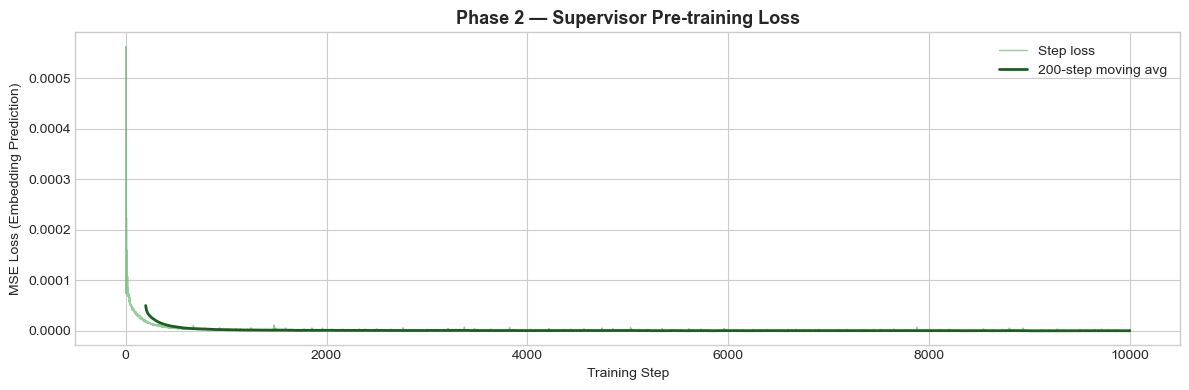

In [15]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(phase2_losses, color='#4CAF50', linewidth=1, alpha=0.6, label='Step loss')

smoothed = pd.Series(phase2_losses).rolling(200).mean()
ax.plot(smoothed, color='#1B5E20', linewidth=2, label='200-step moving avg')

ax.set_title('Phase 2 — Supervisor Pre-training Loss', fontsize=13, fontweight='bold')
ax.set_xlabel('Training Step')
ax.set_ylabel('MSE Loss (Embedding Prediction)')
ax.legend()
plt.tight_layout()
plt.savefig('output/phase2_loss.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Phase 3 — Joint Adversarial Training

All five components are now trained together. The training loop follows the standard GAN alternation, with two modifications specific to TimeGAN:

1. **Generator updates twice per Discriminator update** — this prevents the Discriminator from becoming too strong early and starving the Generator of useful gradient signal (a common failure mode in GAN training)
2. **Five separate loss terms** are tracked independently to diagnose training health:
   - `G_loss_U` — Generator adversarial loss (via Supervisor path)
   - `G_loss_U_e` — Generator adversarial loss (direct, bypassing Supervisor)
   - `G_loss_S` — Supervisor temporal loss
   - `G_loss_V` — Moment matching loss (mean + variance)
   - `D_loss` — Discriminator loss

In [16]:
@tf.function
def train_generator_step(X, Z):
    """One Generator update step — combines 4 loss terms."""
    with tf.GradientTape() as tape:
        # --- Forward pass through all relevant paths ---
        H       = embedder(X, training=True)
        E_hat   = generator(Z, training=True)
        H_hat   = supervisor(E_hat, training=True)
        H_hat_s = supervisor(H, training=True)

        X_hat   = recovery(H_hat, training=True)

        Y_fake   = discriminator(H_hat, training=False)   # Don't update D here
        Y_fake_e = discriminator(E_hat, training=False)

        # --- Loss 1 & 2: Adversarial — Generator wants D to output 1 for fake data ---
        G_loss_U   = adversarial_loss(Y_fake,   is_real=True)
        G_loss_U_e = adversarial_loss(Y_fake_e, is_real=True)

        # --- Loss 3: Supervisor — temporal coherence across latent steps ---
        G_loss_S = reconstruction_loss(H[:, 1:, :], H_hat_s[:, :-1, :])

        # --- Loss 4: Moment matching — statistical fidelity of synthetic output ---
        G_loss_V = moment_loss(X, X_hat)

        # Combined Generator loss; weights from the original paper
        G_loss = (G_loss_U + gamma * G_loss_U_e + 100 * tf.sqrt(G_loss_S) + 100 * G_loss_V)

    vars_ = generator.trainable_variables + supervisor.trainable_variables
    grads = tape.gradient(G_loss, vars_)
    generator_opt.apply_gradients(zip(grads, vars_))
    return G_loss_U, G_loss_U_e, G_loss_S, G_loss_V


@tf.function
def train_embedder_step(X):
    """Fine-tune the Embedder during joint training to keep the latent space grounded."""
    with tf.GradientTape() as tape:
        H       = embedder(X, training=True)
        X_tilde = recovery(H, training=True)
        H_hat_s = supervisor(H, training=True)

        E_loss0 = reconstruction_loss(X, X_tilde)
        E_loss_S = reconstruction_loss(H[:, 1:, :], H_hat_s[:, :-1, :])
        E_loss = 10 * E_loss0 + 0.1 * E_loss_S

    vars_ = embedder.trainable_variables + recovery.trainable_variables
    grads = tape.gradient(E_loss, vars_)
    embedder_opt.apply_gradients(zip(grads, vars_))
    return E_loss


@tf.function
def train_discriminator_step(X, Z):
    """One Discriminator update step — classifies real embeddings vs generated ones."""
    with tf.GradientTape() as tape:
        H       = embedder(X, training=True)
        E_hat   = generator(Z, training=False)  # Don't update G here
        H_hat   = supervisor(E_hat, training=False)

        Y_real   = discriminator(H,     training=True)
        Y_fake   = discriminator(H_hat, training=True)
        Y_fake_e = discriminator(E_hat, training=True)

        D_loss_real   = adversarial_loss(Y_real,   is_real=True)
        D_loss_fake   = adversarial_loss(Y_fake,   is_real=False)
        D_loss_fake_e = adversarial_loss(Y_fake_e, is_real=False)
        D_loss = D_loss_real + D_loss_fake + gamma * D_loss_fake_e

    vars_ = discriminator.trainable_variables
    grads = tape.gradient(D_loss, vars_)
    discriminator_opt.apply_gradients(zip(grads, vars_))
    return D_loss


print('Joint training step functions compiled.')

Joint training step functions compiled.


In [17]:
print('Phase 3: Joint adversarial training')
print(f'Steps: {joint_train_steps:,}  |  2 Generator updates per Discriminator update')
print(f'Logging every 1,000 steps')
print('-' * 70)

phase3_losses = {'G_U': [], 'G_U_e': [], 'G_S': [], 'G_V': [], 'D': []}

for step in range(joint_train_steps):
    X_batch = next(real_iter)

    # --- Generator updates (×2) ---
    for _ in range(2):
        Z_batch = get_noise()
        G_U, G_U_e, G_S, G_V = train_generator_step(X_batch, Z_batch)

    # --- Embedder update (keeps reconstruction tight during adversarial phase) ---
    train_embedder_step(X_batch)

    # --- Discriminator update (×1) ---
    Z_batch = get_noise()
    D = train_discriminator_step(X_batch, Z_batch)

    phase3_losses['G_U'].append(float(G_U))
    phase3_losses['G_U_e'].append(float(G_U_e))
    phase3_losses['G_S'].append(float(G_S))
    phase3_losses['G_V'].append(float(G_V))
    phase3_losses['D'].append(float(D))

    if (step + 1) % 1000 == 0:
        print(f'  Step {step+1:>6,}  |  G_U={G_U:.4f}  G_S={G_S:.4f}  G_V={G_V:.4f}  D={D:.4f}')

print('Phase 3 complete.')

Phase 3: Joint adversarial training
Steps: 10,000  |  2 Generator updates per Discriminator update
Logging every 1,000 steps
----------------------------------------------------------------------
  Step  1,000  |  G_U=1.3281  G_S=0.0001  G_V=0.0473  D=1.5106
  Step  2,000  |  G_U=1.1633  G_S=0.0001  G_V=0.0324  D=1.6394
  Step  3,000  |  G_U=1.4264  G_S=0.0001  G_V=0.0132  D=1.6045
  Step  4,000  |  G_U=1.2000  G_S=0.0002  G_V=0.0441  D=1.6203
  Step  5,000  |  G_U=1.3612  G_S=0.0002  G_V=0.0177  D=1.5358
  Step  6,000  |  G_U=1.2567  G_S=0.0001  G_V=0.0251  D=1.6328
  Step  7,000  |  G_U=1.3000  G_S=0.0001  G_V=0.0256  D=1.5928
  Step  8,000  |  G_U=1.2679  G_S=0.0001  G_V=0.0243  D=1.6877
  Step  9,000  |  G_U=1.2961  G_S=0.0001  G_V=0.0201  D=1.7388
  Step 10,000  |  G_U=1.3986  G_S=0.0001  G_V=0.0408  D=1.6943
Phase 3 complete.


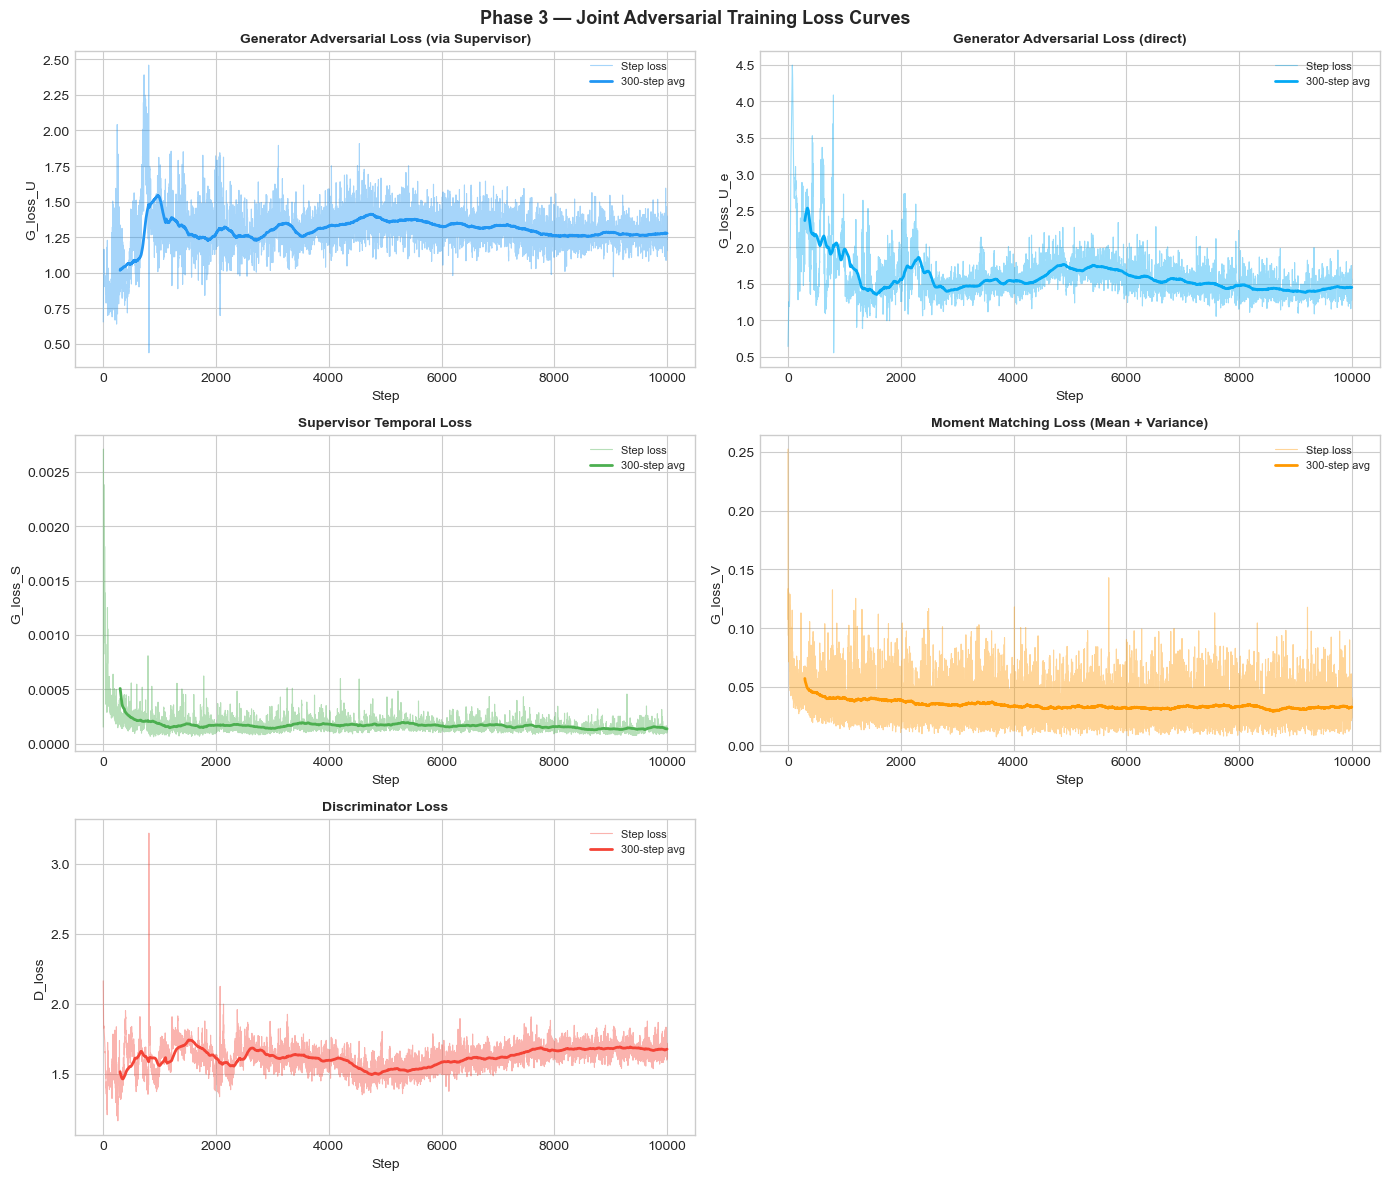

In [18]:
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

loss_specs = [
    ('G_U',   '#2196F3', 'Generator Adversarial Loss (via Supervisor)',   'G_loss_U'),
    ('G_U_e', '#03A9F4', 'Generator Adversarial Loss (direct)',           'G_loss_U_e'),
    ('G_S',   '#4CAF50', 'Supervisor Temporal Loss',                     'G_loss_S'),
    ('G_V',   '#FF9800', 'Moment Matching Loss (Mean + Variance)',        'G_loss_V'),
    ('D',     '#F44336', 'Discriminator Loss',                            'D_loss'),
]

for i, (key, color, title, ylabel) in enumerate(loss_specs):
    vals = phase3_losses[key]
    axes[i].plot(vals, color=color, linewidth=0.8, alpha=0.4, label='Step loss')
    smoothed = pd.Series(vals).rolling(300).mean()
    axes[i].plot(smoothed, color=color, linewidth=2, label='300-step avg')
    axes[i].set_title(title, fontsize=10, fontweight='bold')
    axes[i].set_xlabel('Step')
    axes[i].set_ylabel(ylabel)
    axes[i].legend(fontsize=8)

axes[-1].axis('off')  # Hide unused 6th subplot
fig.suptitle('Phase 3 — Joint Adversarial Training Loss Curves', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('output/phase3_losses.png', dpi=150, bbox_inches='tight')
plt.show()

## 12. Generate Synthetic Data

We generate exactly `n_windows` synthetic windows to match the real dataset size — this ensures the evaluation metrics in Notebook 3 use balanced sample sizes. The synthetic data is produced in the inference path: noise → Generator → Supervisor → Recovery.

In [19]:
os.makedirs('output', exist_ok=True)

print(f'Generating {n_windows} synthetic windows...')

# Generate in batches to avoid OOM on large n_windows
generated_batches = []
n_batches = int(np.ceil(n_windows / batch_size))

for _ in range(n_batches):
    Z = get_noise(batch_sz=batch_size)
    X_hat_batch = synthetic_data(Z, training=False).numpy()
    generated_batches.append(X_hat_batch)

# Concatenate and trim to exact n_windows (last batch may be larger)
generated_data = np.concatenate(generated_batches, axis=0)[:n_windows]
print(f'Generated data shape (normalised): {generated_data.shape}')

# --- Inverse-transform to original price scale ---
# Reshape to 2D for the scaler, then back to 3D
gen_2d = generated_data.reshape(-1, n_seq)
gen_rescaled_2d = scaler.inverse_transform(gen_2d)
generated_data_rescaled = gen_rescaled_2d.reshape(n_windows, seq_len, n_seq)

print(f'Generated data shape (rescaled):   {generated_data_rescaled.shape}')
print(f'Value range (normalised):          [{generated_data.min():.4f}, {generated_data.max():.4f}]')
print(f'Rescaled SPY range approx:         [{generated_data_rescaled[:,:,0].min():.2f}, {generated_data_rescaled[:,:,0].max():.2f}]')

# --- Save outputs ---
np.save('output/generated_data.npy', generated_data)
np.save('output/generated_data_rescaled.npy', generated_data_rescaled)

training_losses = {'phase1': phase1_losses, 'phase2': phase2_losses, 'phase3': phase3_losses}
with open('output/training_losses.pkl', 'wb') as f:
    pickle.dump(training_losses, f)

print('\nSaved:')
for fname in ['output/generated_data.npy', 'output/generated_data_rescaled.npy', 'output/training_losses.pkl']:
    size = os.path.getsize(fname)
    print(f'  {fname:<45}  ({size/1024:.1f} KB)')

Generating 3750 synthetic windows...
Generated data shape (normalised): (3750, 24, 6)
Generated data shape (rescaled):   (3750, 24, 6)
Value range (normalised):          [0.0064, 0.9624]
Rescaled SPY range approx:         [85.13, 534.30]

Saved:
  output/generated_data.npy                      (2109.5 KB)
  output/generated_data_rescaled.npy             (2109.5 KB)
  output/training_losses.pkl                     (615.5 KB)


## 13. Visual Sanity Check

Before moving to the rigorous evaluation in Notebook 3, we do a quick qualitative inspection: plot 3 randomly chosen synthetic windows side-by-side with 3 real windows for each ticker.

This is not a statistical test — it's a sanity check to catch obvious failures (e.g. flat outputs, extreme oscillations) before investing compute in the full evaluation.

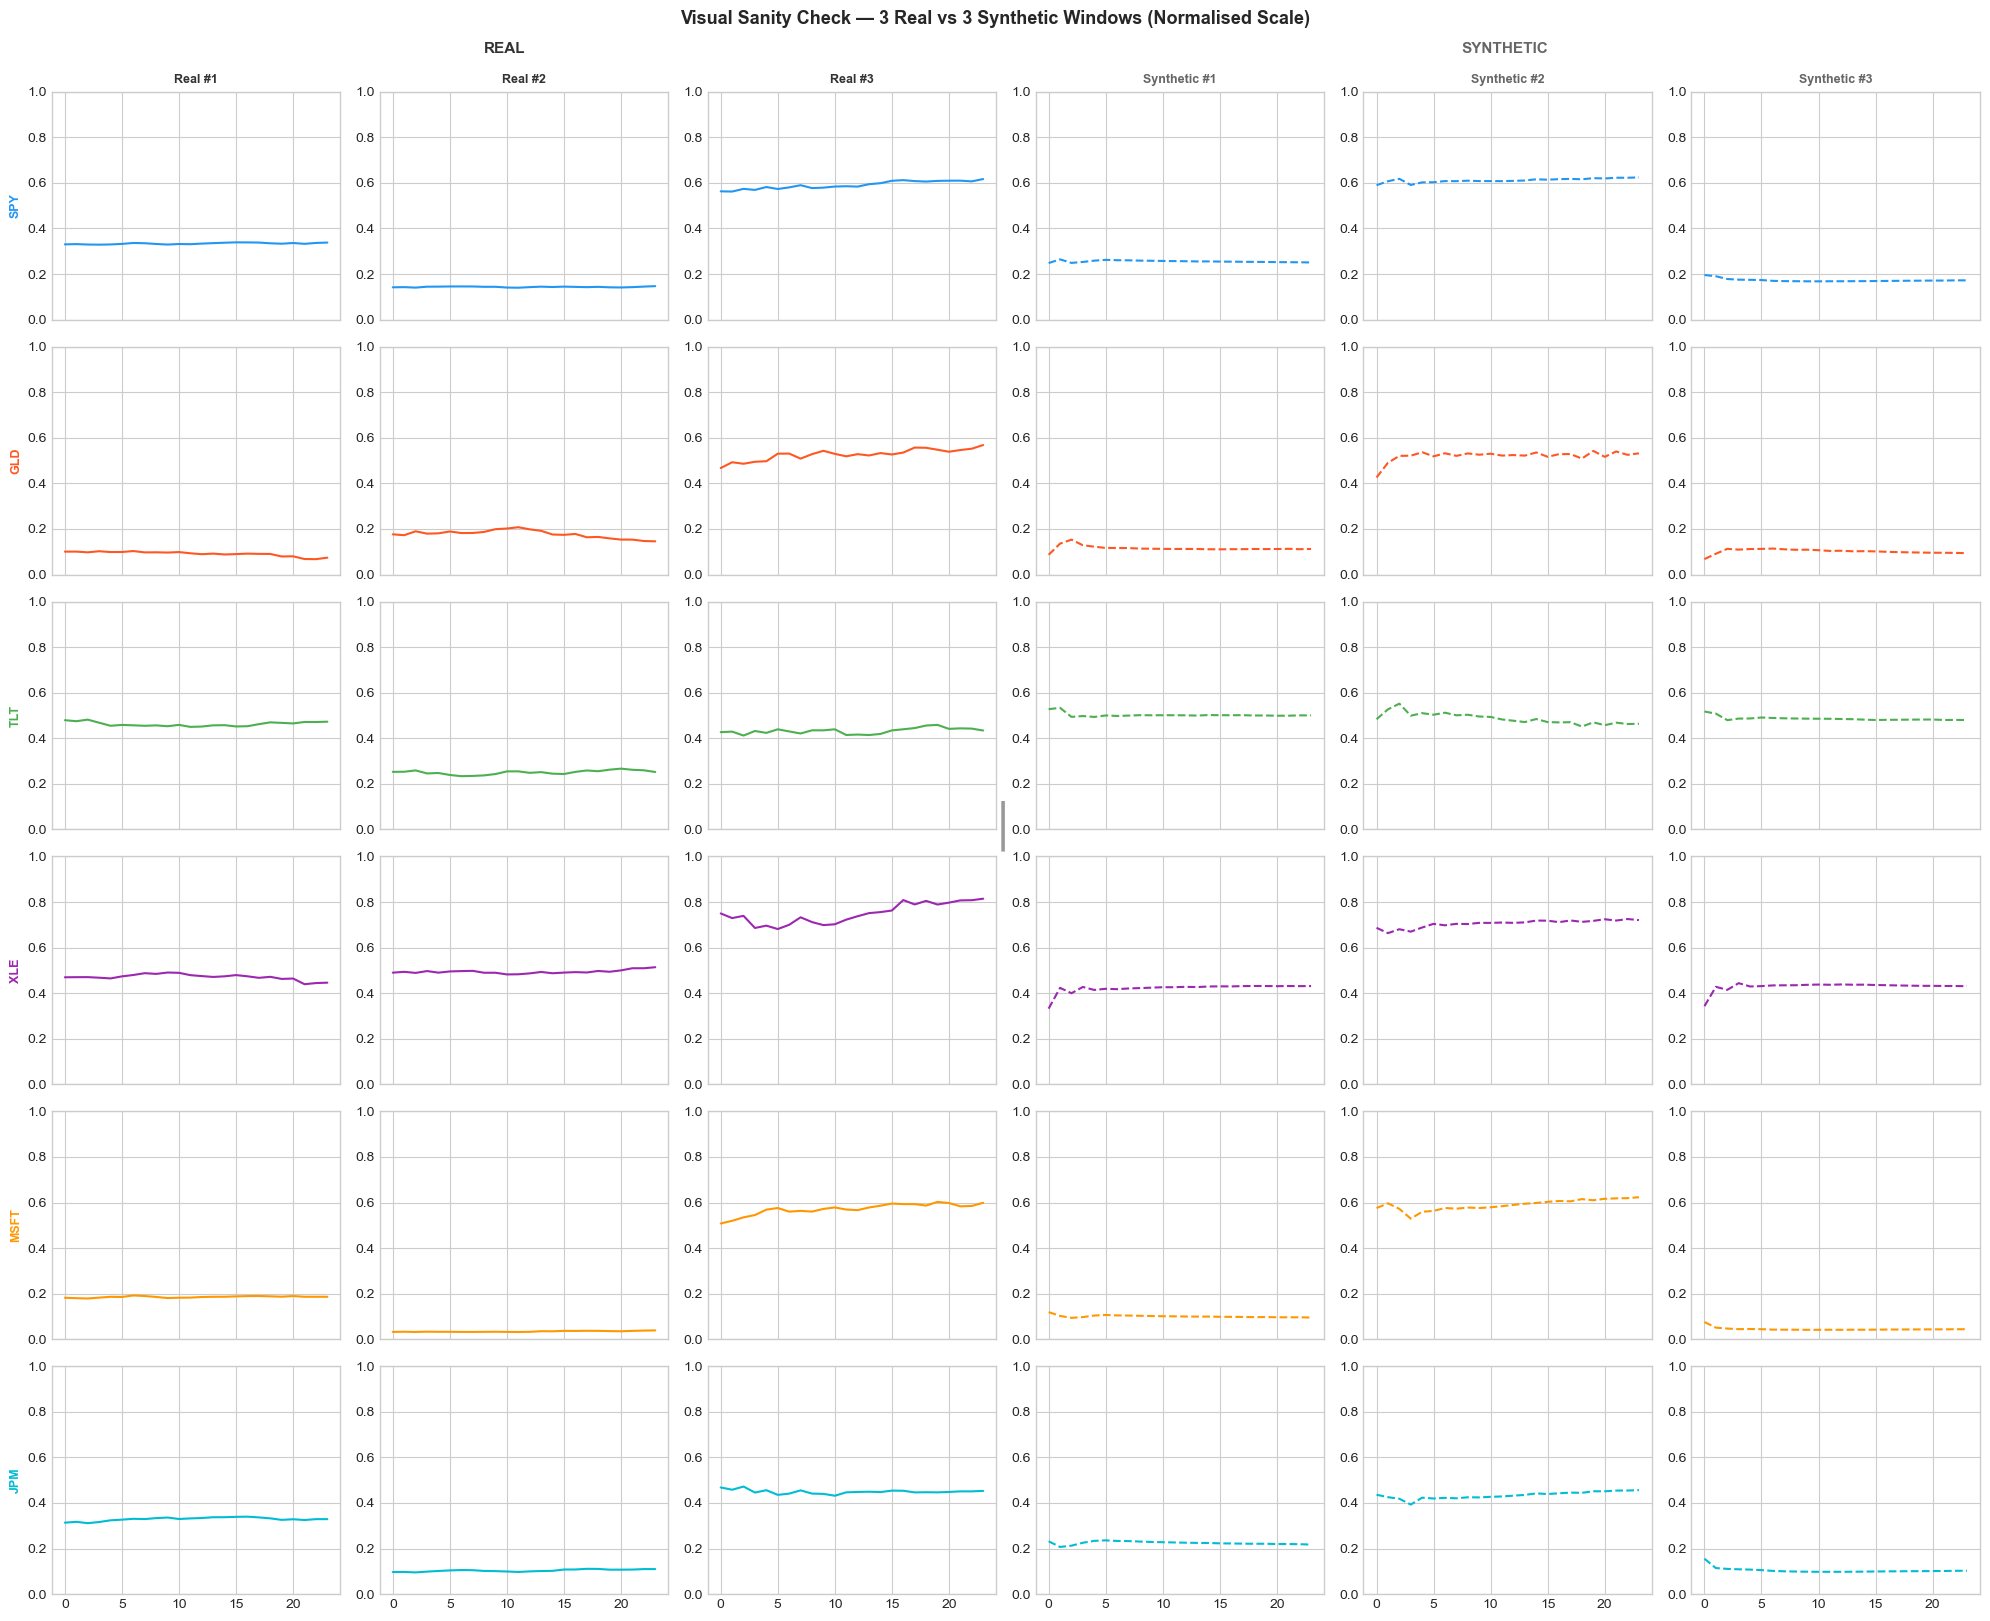

Sanity check complete. Proceed to Notebook 3 for rigorous evaluation.


In [ ]:
np.random.seed(SEED)
real_idx = np.random.choice(n_windows, size=3, replace=False)
fake_idx = np.random.choice(n_windows, size=3, replace=False)

fig, axes = plt.subplots(n_seq, 6, figsize=(20, 16), sharex=True)

for row, ticker in enumerate(TICKERS):
    color = COLORS[row]

    for col, idx in enumerate(real_idx):
        axes[row, col].plot(windows[idx, :, row], color=color, linewidth=1.5)
        axes[row, col].set_ylim(0, 1)
        if row == 0:
            axes[row, col].set_title(f'Real #{col+1}', fontsize=9, fontweight='bold', color='#333')
        if col == 0:
            axes[row, col].set_ylabel(ticker, fontsize=9, fontweight='bold', color=color)

    for col, idx in enumerate(fake_idx):
        axes[row, col + 3].plot(generated_data[idx, :, row], color=color, linewidth=1.5, linestyle='--')
        axes[row, col + 3].set_ylim(0, 1)
        if row == 0:
            axes[row, col + 3].set_title(f'Synthetic #{col+1}', fontsize=9, fontweight='bold', color='#666')

# Vertical separator between real and synthetic panels
fig.text(0.505, 0.5, '│', ha='center', va='center', fontsize=30, color='#999', transform=fig.transFigure)
fig.text(0.255, 0.99, 'REAL', ha='center', va='top', fontsize=11, fontweight='bold', color='#333')
fig.text(0.755, 0.99, 'SYNTHETIC', ha='center', va='top', fontsize=11, fontweight='bold', color='#666')

fig.suptitle('Visual Sanity Check — 3 Real vs 3 Synthetic Windows (Normalised Scale)', 
             fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('output/sanity_check.png', dpi=150, bbox_inches='tight')
plt.show()

print('Sanity check complete. Proceed to Notebook 3 for rigorous evaluation.')